In [1]:
seed = 123

In [2]:
# import helper functions
from shutil import copyfile

copyfile(
    src = "/kaggle/input/bdc-p53/p53_helper_functions.py", 
    dst = "/kaggle/working/p53_helpers.py"
)

from p53_helpers import *

# load dataset (no NAs)
X, Y = load_p53_ds()
# sratified 80/20 split
X_train, X_test, Y_train, Y_test = split_p53(X, Y)

Using TensorFlow backend.



Import completed after 2.8 sec

CLASS RATIOS
Training set active classes:   121/24927 (0.485 %)
Test set active classes:       30/6232 (0.481 %)

MATRIX DIMENSIONS
TRAINING SET
. Features:   (24927, 5408)
. Classes:    (24927,)
TEST SET
. Features:   (6232, 5408)
. Classes:    (6232,)


In [3]:
# preprocessing for LR
FU = FeatureUnion([
    ("pca", PCA(n_components = 10)),
    ("fs_univ_F", SelectKBest(f_classif, k=5)),
    ("fs_model", SelectFromModel(
        LinearSVC(max_iter=15000, random_state=seed, class_weight="balanced"), threshold=-np.inf, max_features=1000)
    )
])

pipe = Pipeline([
    ("ss", StandardScaler()),
    ("pp", FU)
])

In [4]:
X_train_prepped = pipe.fit_transform(X_train, Y_train)
X_test_prepped = pipe.transform(X_test)

/opt/conda/lib/python3.7/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [5]:
LR = LogisticRegression(max_iter=5000, penalty="l2", C=1, class_weight={0:0.05, 1:0.95}, random_state=seed)
LR.fit(X_train_prepped, Y_train)
Y_test_proba_LR = LR.predict_proba(X_test_prepped)[:, 1]    # estimated P(class == "active")

In [6]:
# RFC (CSL, no resampling)
FU = FeatureUnion([
    ("fs_univ", SelectKBest(f_classif, k=20)),
    ("fs_model", SelectFromModel(
        ExtraTreesClassifier(n_estimators=100, random_state=seed), threshold=-np.inf, max_features=125)
    )
])

pipe = Pipeline([
    ("remove_corr", RemoveCorrelatedFeatures(n_remove=250)),
    ("scale", StandardScaler()),
    ("fs", FU)
])

X_train_prepped = pipe.fit_transform(X_train, Y_train)
X_test_prepped = pipe.transform(X_test)

In [7]:
RFC = RandomForestClassifier(random_state=seed, min_samples_leaf=10, n_estimators=500, max_depth=10, class_weight={0:0.01, 1:0.99})
RFC.fit(X_train_prepped, Y_train)
Y_test_proba_RFC = RFC.predict_proba(X_test_prepped)[:, 1]    # estimated P(class == "active")

In [8]:
# NN preprocessing

In [9]:
# make model and return the prop of the minority class to allow optimization the class weights
def make_model(
    x, y,
    u1=256,
    d1=0.5,
    lr=0.001,
    smart_init=True
):
    
    # define metrics
    metrics = [
        mcc,
        keras.metrics.TruePositives(name='tp'),
        keras.metrics.FalsePositives(name='fp'),
        keras.metrics.TrueNegatives(name='tn'),
        keras.metrics.FalseNegatives(name='fn'), 
        keras.metrics.BinaryAccuracy(name='accuracy'),
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc', curve="PR")
    ]
    
    if smart_init:
        n_active = y.sum()
        n_inactive = len(y) - n_active
        b0 = tf.keras.initializers.Constant(np.log([n_active / n_inactive]))
    else:
        b0=None # random initialization

    # build & compile
    model = keras.Sequential([
        keras.layers.Dense(u1, activation='relu', input_shape=(x.shape[-1], )),
        keras.layers.Dropout(d1),
        keras.layers.Dense(1, activation='sigmoid', bias_initializer=b0)
    ])
    
    model.compile(
        optimizer=keras.optimizers.Adam(lr=lr),
        loss=keras.losses.BinaryCrossentropy(),
        metrics=metrics
    )
    
    return model

In [10]:
X_train, Y_train = np.array(X_train), np.array(Y_train)

# Preprocessing
pipe = Pipeline([
    ("scale", StandardScaler()),
    ("clip", ClipFeatures(c=3))
])

X_train_prepped = pipe.fit_transform(X_train, Y_train)

X_test, Y_test = np.array(X_test), np.array(Y_test)
X_test_prepped = pipe.transform(X_test)

In [11]:
NN = make_model(x=X_train_prepped, y=Y_train, lr=0.001)

history = NN.fit(
    X_train_prepped,
    Y_train,
    batch_size=4096,
    epochs=65,
    verbose=0,
    class_weight={0: 0.15, 1: 0.85}
)

In [12]:
Y_test_proba_NN = NN.predict_proba(X_test_prepped)

In [13]:
# check estimated probabilities
print(Y_test_proba_LR.shape)
print(Y_test_proba_RFC.shape)
print(Y_test_proba_NN.shape)

(6232,)
(6232,)
(6232, 1)


In [14]:
Y_test_proba_NN = Y_test_proba_NN.flatten()

In [15]:
# soft voting: avg probability (equal weight)
Y_test_avg_proba = np.mean([Y_test_proba_LR, Y_test_proba_RFC, Y_test_proba_NN], axis=0)

Model 1
--------------------------------------------------------------------------------
Precision:     65.71%
Recall:        76.67%
AUCPR:         58.64%
F1:            70.77%
MCC:           70.83%



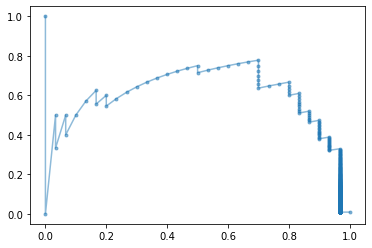

In [16]:
Y_pred = (Y_test_avg_proba > 0.5).astype('int')
prec, rec, t = precision_recall_curve(Y_test, Y_test_avg_proba)

print(f"Model 1\n{'-' * 80}")
print(f"Precision:     {precision_score(Y_test, Y_pred):.2%}")
print(f"Recall:        {recall_score(Y_test, Y_pred):.2%}")
print(f"AUCPR:         {auc(rec, prec):.2%}")
print(f"F1:            {f1_score(Y_test, Y_pred):.2%}")
print(f"MCC:           {matthews_corrcoef(Y_test, Y_pred):.2%}")
print()

plt.plot(rec, prec, marker='.', label="ensemble", alpha=0.5)

Model LR
--------------------------------------------------------------------------------
Precision:     48.94%
Recall:        76.67%
AUCPR:         54.17%
F1:            59.74%
MCC:           61.03%

Model RFC
--------------------------------------------------------------------------------
Precision:     51.52%
Recall:        56.67%
AUCPR:         48.14%
F1:            53.97%
MCC:           53.80%

Model NN
--------------------------------------------------------------------------------
Precision:     62.16%
Recall:        76.67%
AUCPR:         68.12%
F1:            68.66%
MCC:           68.87%

Model Ensemble
--------------------------------------------------------------------------------
Precision:     65.71%
Recall:        76.67%
AUCPR:         58.64%
F1:            70.77%
MCC:           70.83%



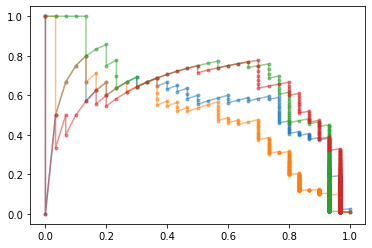

In [17]:
# Plot all
for name, y_proba in zip(
    ["LR", "RFC", "NN", "Ensemble"],
    [Y_test_proba_LR, Y_test_proba_RFC, Y_test_proba_NN, Y_test_avg_proba]
):
    
    Y_pred = (y_proba > 0.5).astype("int")
    
    prec, rec, t = precision_recall_curve(Y_test, y_proba)
    plt.plot(rec, prec, marker='.', label=name, alpha=0.5)
    
    print(f"Model {name}\n{'-' * 80}")
    print(f"Precision:     {precision_score(Y_test, Y_pred):.2%}")
    print(f"Recall:        {recall_score(Y_test, Y_pred):.2%}")
    print(f"AUCPR:         {auc(rec, prec):.2%}")
    print(f"F1:            {f1_score(Y_test, Y_pred):.2%}")
    print(f"MCC:           {matthews_corrcoef(Y_test, Y_pred):.2%}")
    print()

In [18]:
# confusion matrix of Ensemble classifier
from sklearn.metrics import confusion_matrix

Y_pred = (Y_test_avg_proba > 0.5).astype('int')

print(confusion_matrix(Y_test, Y_pred))

[[6190   12]
 [   7   23]]
